## The purpose of this notebook is to study relationships between different entities within the transaction data through regression analysis.
 - in partticular, we want to answer the questions whether merchant grow their spending over time. 
 - for simplistic demonstration, we start by running regression on total spent over price, does total spent grow as price increases?
 - note that this may not be a good example of questions, because we have created some correlation already by computiing spent as multiplication of quantity and price price. 
 - a better question to ask is: do merchants increase their spent as their tenures increase? 

### setting up data and utility functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def add_date_cols(baskets):
    baskets['datetime'] = pd.to_datetime(baskets['placed_at'])
    baskets['year'] = baskets["datetime"].dt.year
    baskets['month'] = baskets["datetime"].dt.month
    baskets['date'] = baskets["datetime"].dt.date
    baskets['day'] = baskets["datetime"].dt.day
    baskets['hour'] = baskets["datetime"].dt.hour
    baskets['weekday'] = baskets["datetime"].dt.weekday
    baskets['year_month'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%m"))
    baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
    baskets['year_week'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
    baskets['week_num'] = baskets["datetime"].apply(lambda t: int(t.strftime("%W"))) 
    baskets['iso_week_num'] = baskets["datetime"].dt.isocalendar().week # this returns week number 52 for Jan 1, 2021, not 0 which is what we want
    baskets['cum_week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
    return baskets
def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat','nunique'), 
        num_sub_cats = ('sub_cat','nunique'),
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    return merchant_attributes

### preparing the analysis table
 - unit of study is SKU, so we may want to start with a table for SKU attributes, each row for one SKU


In [3]:
def get_sku_attributes(baskets):
    sku_attributes = baskets.groupby(['sku_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_merchants = ('merchant_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        first_week = ('week_num', 'min'), 
        last_week = ('week_num', 'max'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
    ).reset_index()
    sku_attributes['avg_spent_per_order'] = sku_attributes.total_spent / sku_attributes.num_orders
    sku_attributes['tenure_month'] = sku_attributes.last_month - sku_attributes.first_month +1
    return sku_attributes

 - the values of study are price and spent, but we don't want just one average price and one total spent for the SKU over all times
 - we want to study the changes in spent over price, we want to keep some dimension for variances in the analysis table
 - we can start with price and spent on each week over all merchants: then we want to compute the average price for the week and total spent by the week, for all merchants

In [4]:
def get_skus_by_week(baskets):
    skus_by_week = baskets.groupby(['sku_id','year_week']).agg(
        avg_price_by_week = ('price','mean'),
        num_order_by_week = ('order_id', 'nunique'), 
        num_merchants_by_week = ('merchant_id', 'nunique'),
        total_spent_by_week = ('spent', 'sum'),
    ).reset_index()
    return skus_by_week

In [5]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [6]:
sku_week = get_skus_by_week(baskets)

In [7]:
sku_week.describe()

,sku_id,avg_price_by_week,num_order_by_week,num_merchants_by_week,total_spent_by_week
count,54344.000000,5.434400e+04,54344.000000,54344.000000,5.434400e+04
mean,1100.121467,1.155972e+05,9.061350,5.560614,1.561432e+06
std,426.431588,3.116036e+05,20.265732,8.749830,6.147552e+06
min,1.000000,1.331019e+02,1.000000,1.000000,1.000000e+03
25%,816.000000,1.450000e+04,2.000000,1.000000,9.950000e+04
50%,1125.000000,4.100000e+04,4.000000,3.000000,2.700000e+05
75%,1453.000000,1.220000e+05,8.000000,6.000000,8.052500e+05
max,1860.000000,4.240000e+06,349.000000,133.000000,1.264344e+08


In [61]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]
top_skus.head(20)

,sku_id
1503,1504
866,867
1512,1513
873,874
971,972
984,985
970,971
991,992
1337,1338
972,973


### Use sns.regplot to inspect regressions

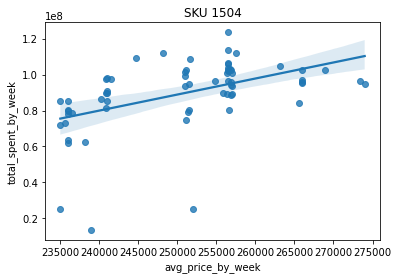

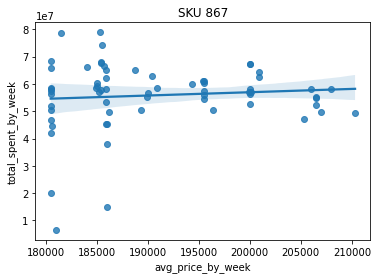

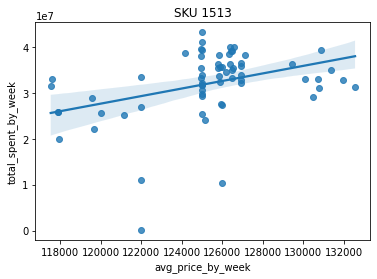

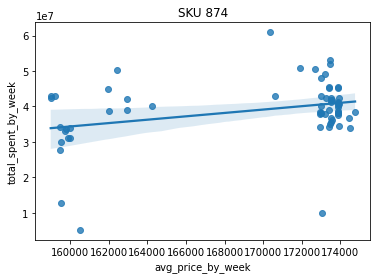

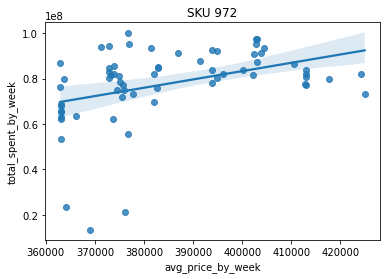

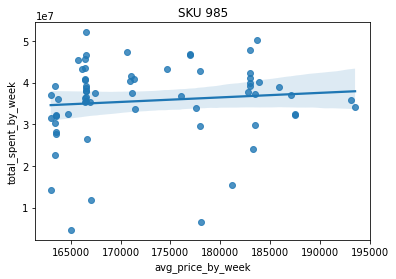

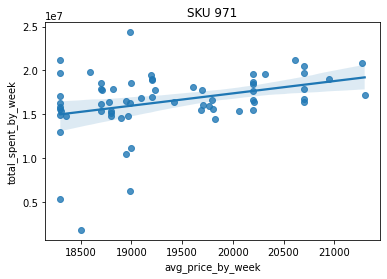

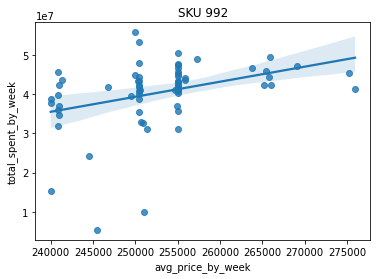

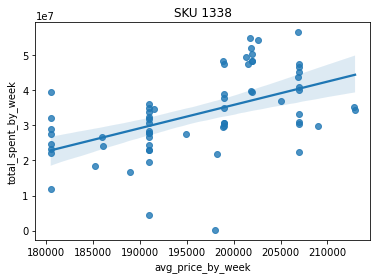

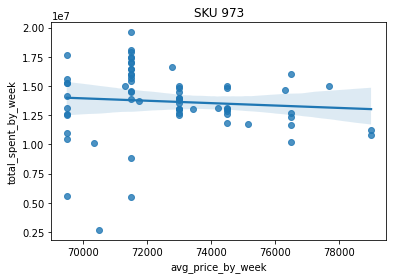

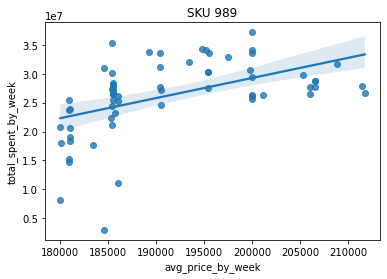

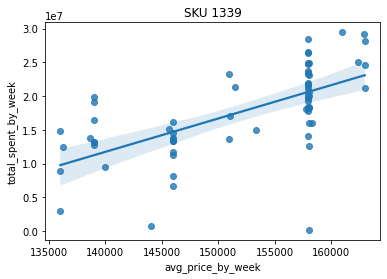

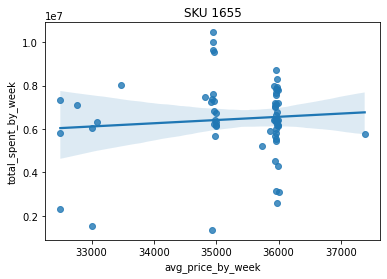

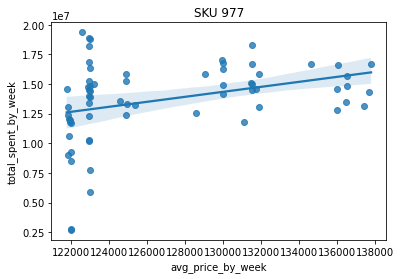

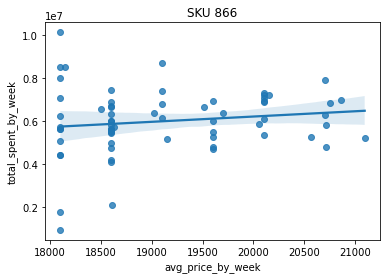

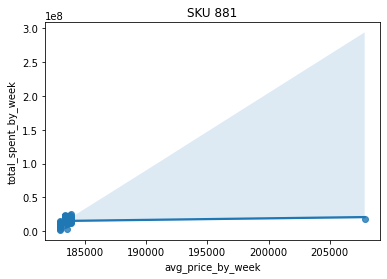

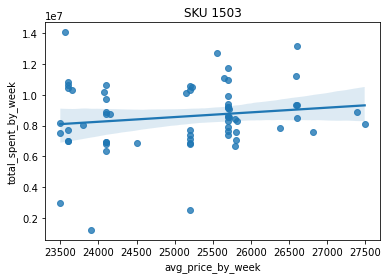

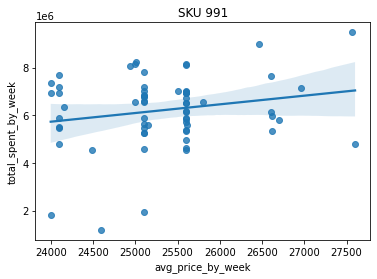

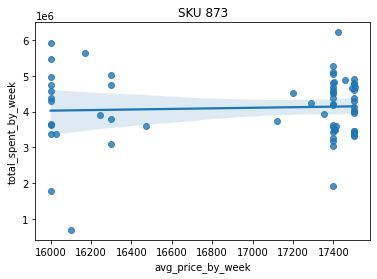

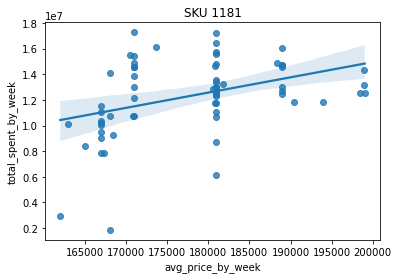

In [62]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    plt.figure(sku_id)
    sns.regplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week").set(title = "SKU " + str(sku_id))

 - plotting residuals next to regression plot

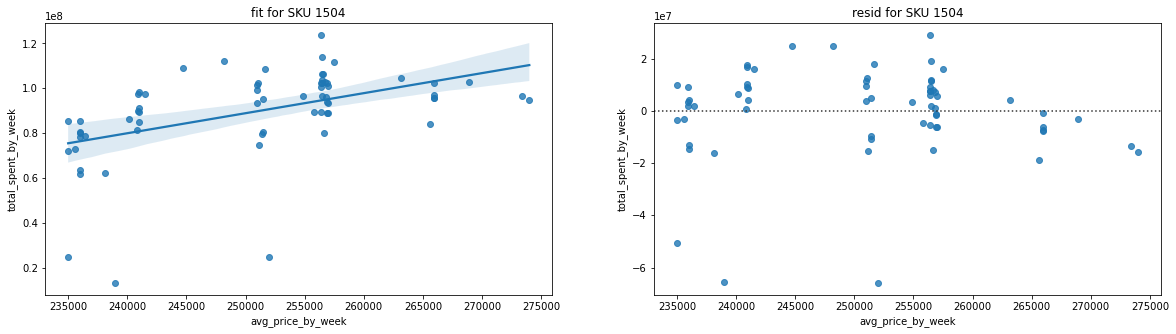

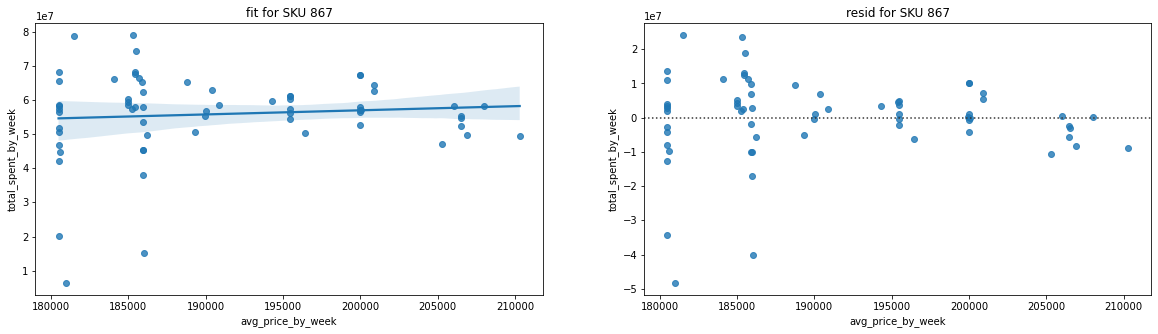

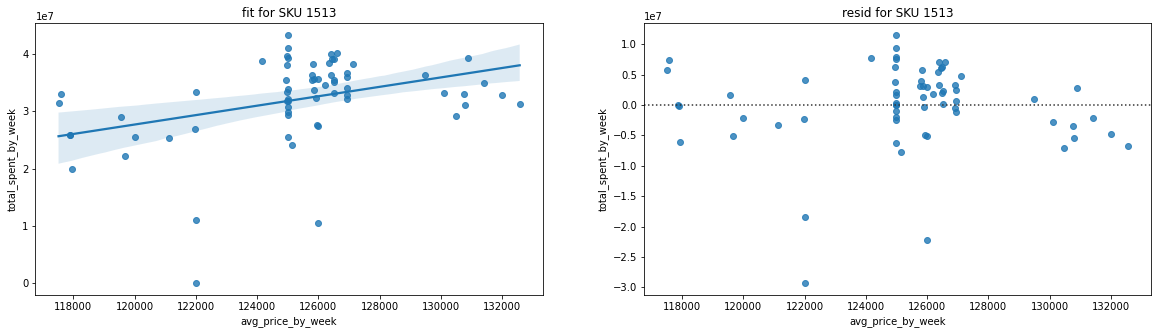

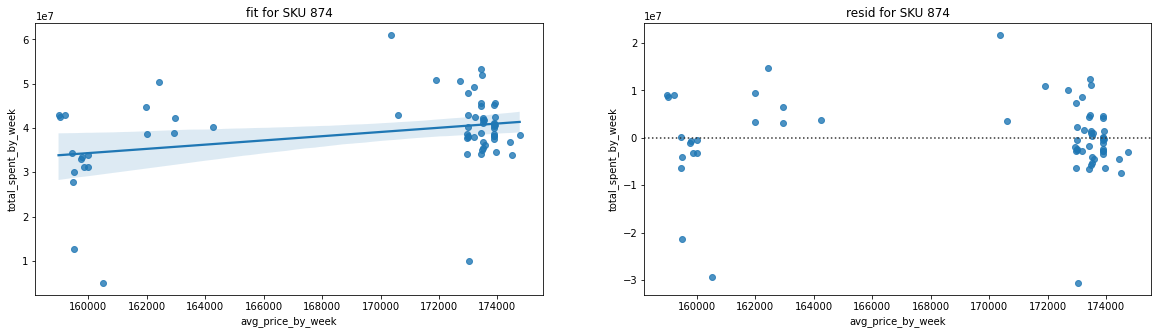

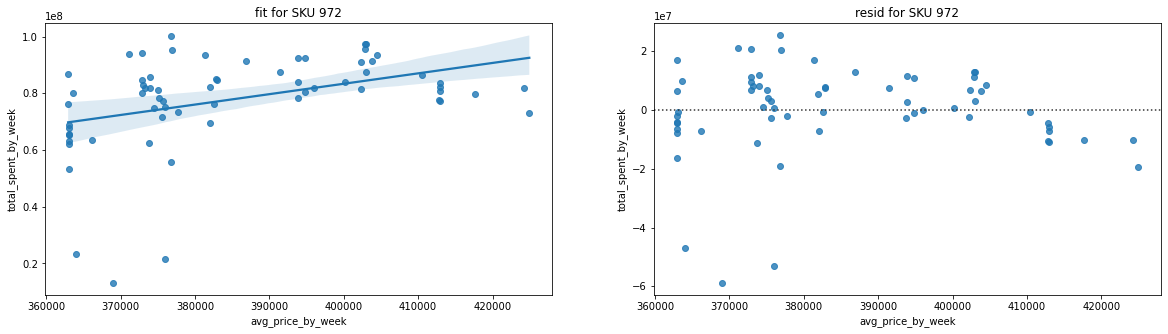

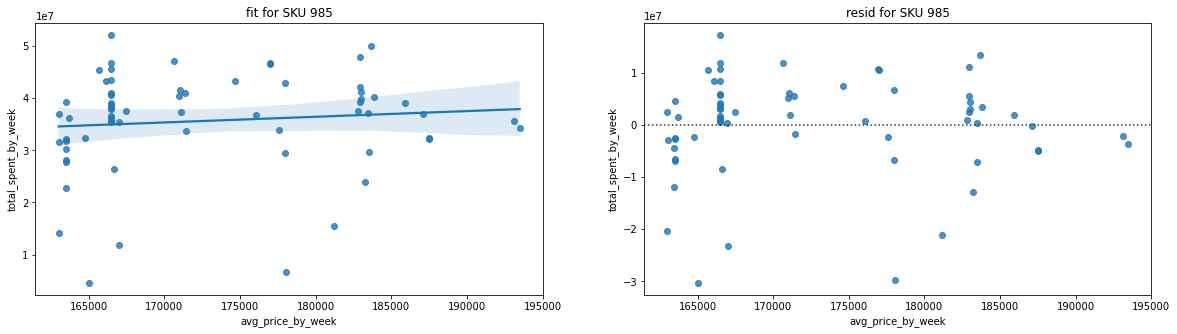

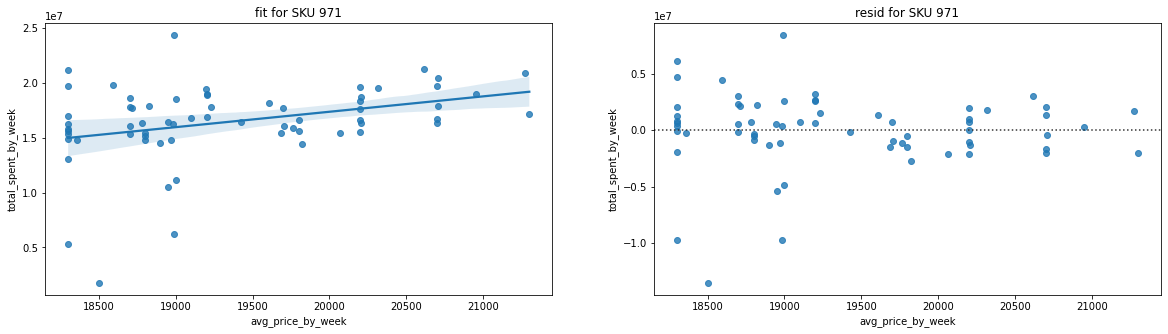

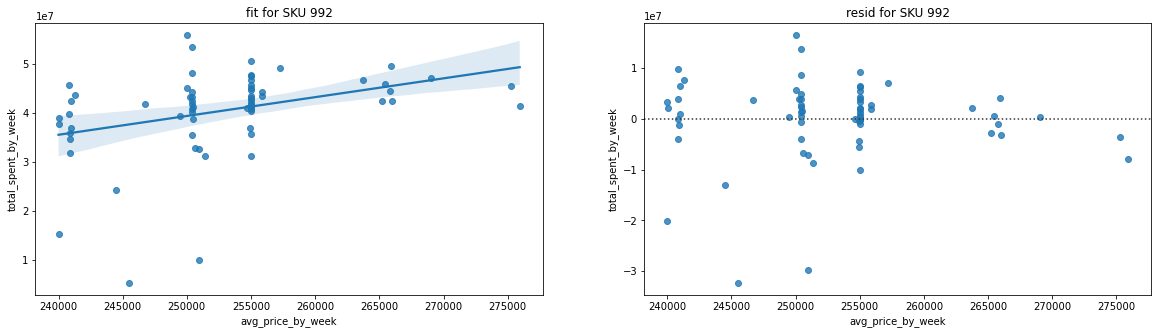

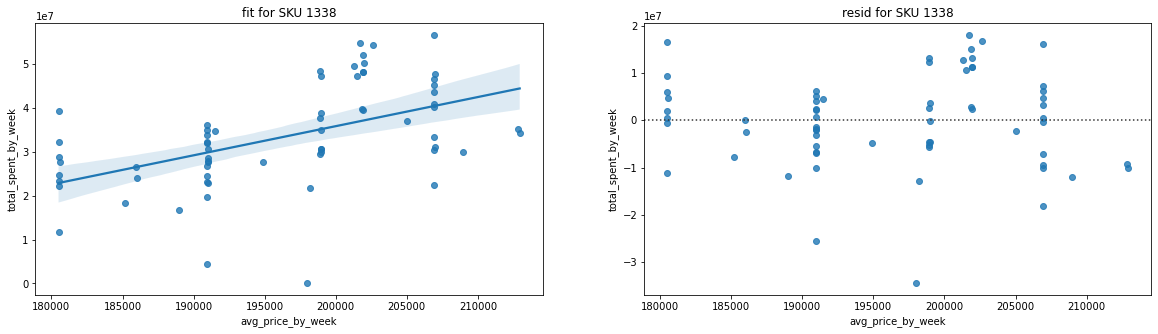

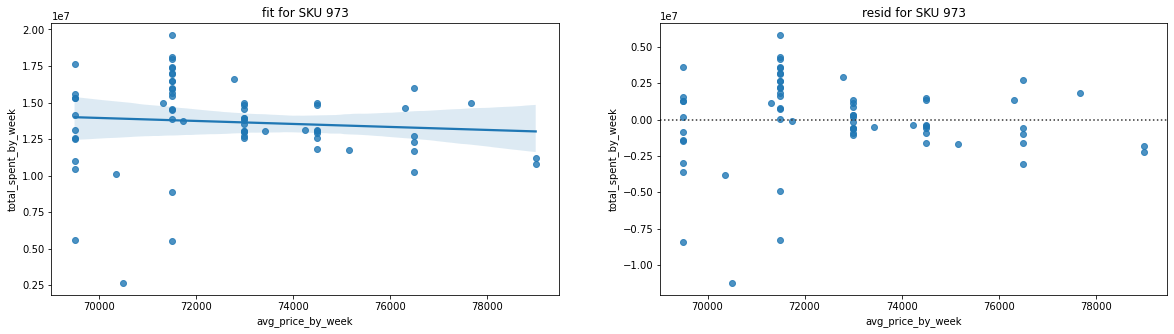

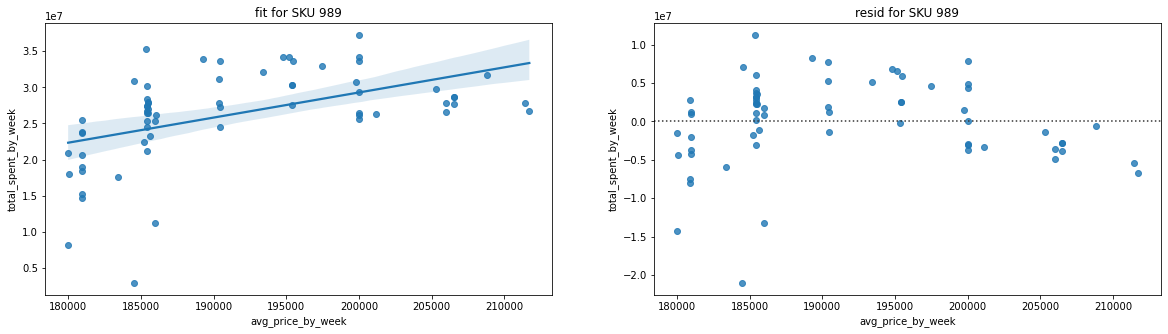

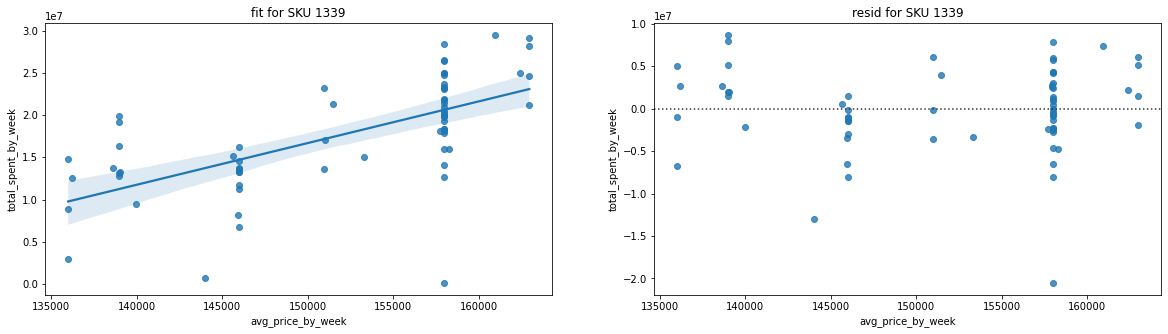

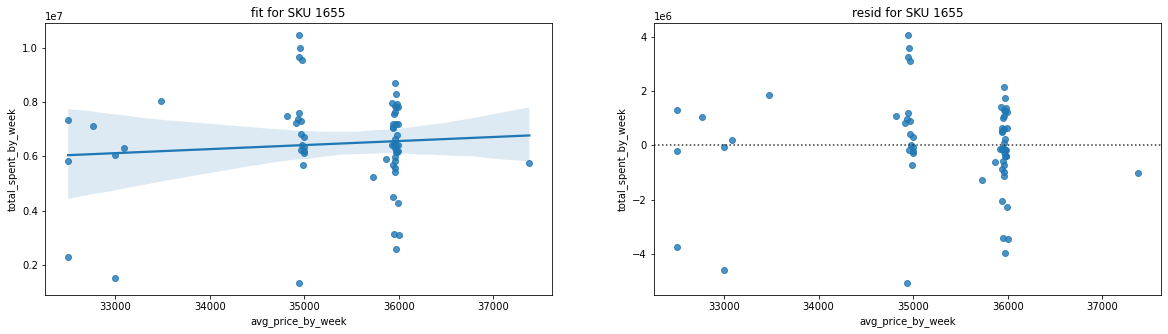

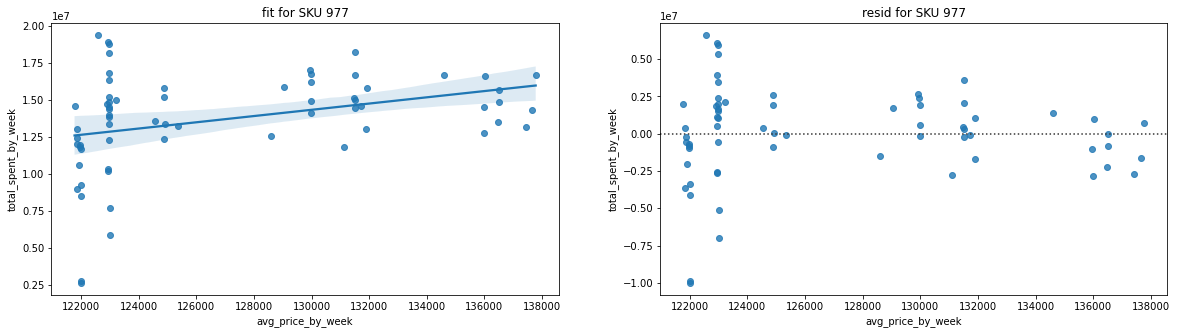

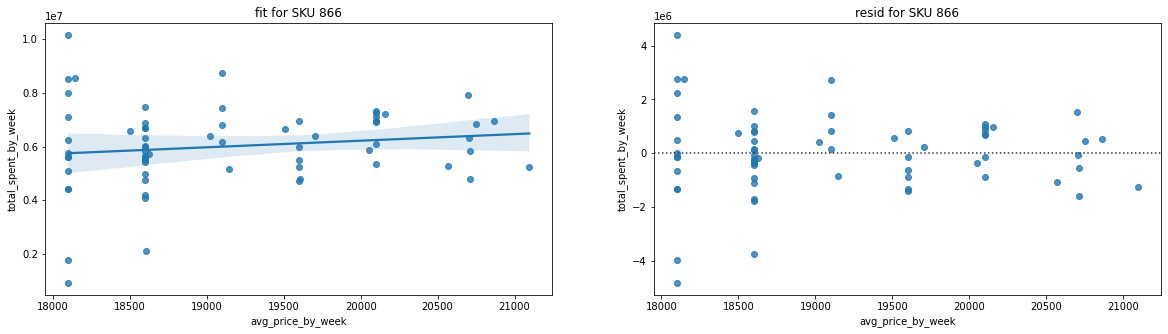

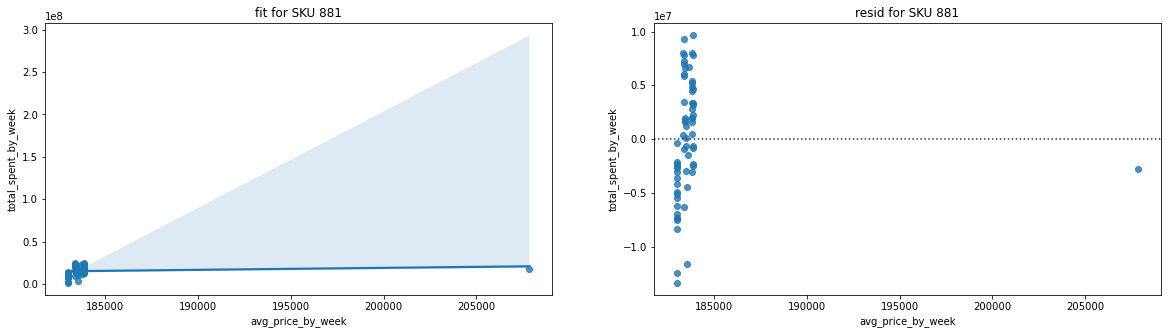

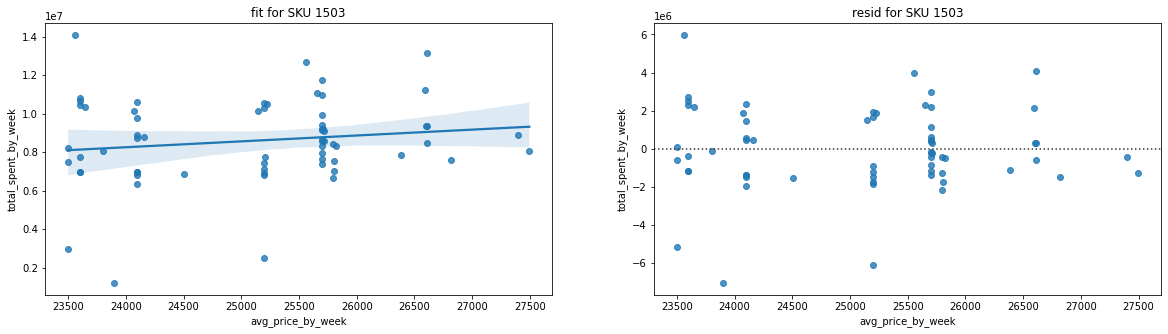

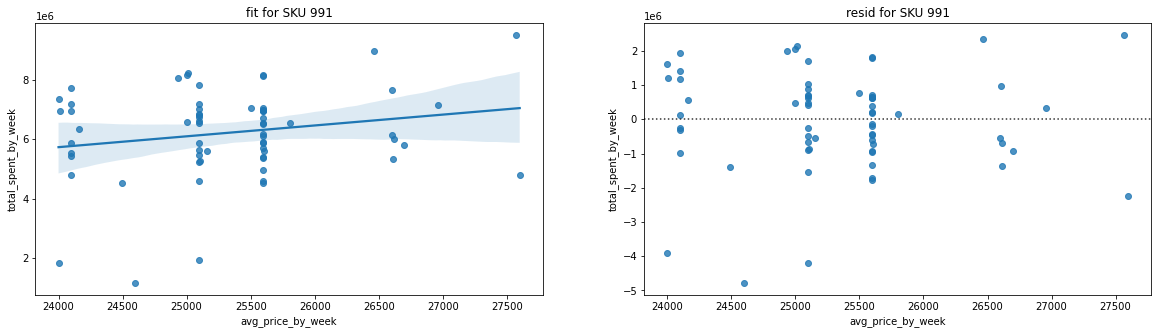

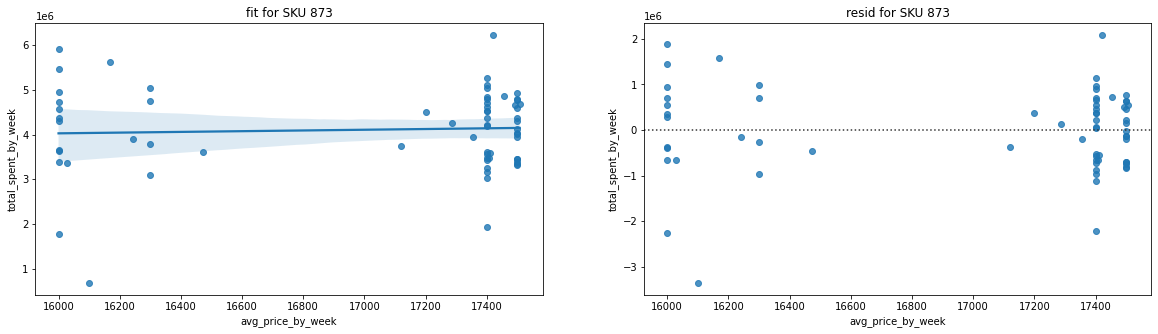

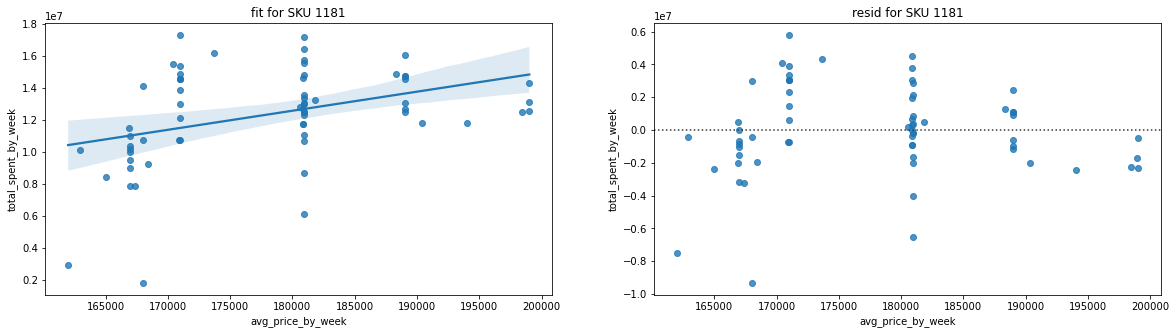

In [10]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    #plt.figure(sku_id)
    f, axes = plt.subplots(1, 2, figsize = (20,5))
    sns.regplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week", ax=axes[0])
    sns.residplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week",ax=axes[1])
    axes[0].set(title = "fit for SKU " + str(sku_id))
    axes[1].set(title = "resid for SKU " + str(sku_id))


### pick some randome SKUs to study further

<AxesSubplot:>

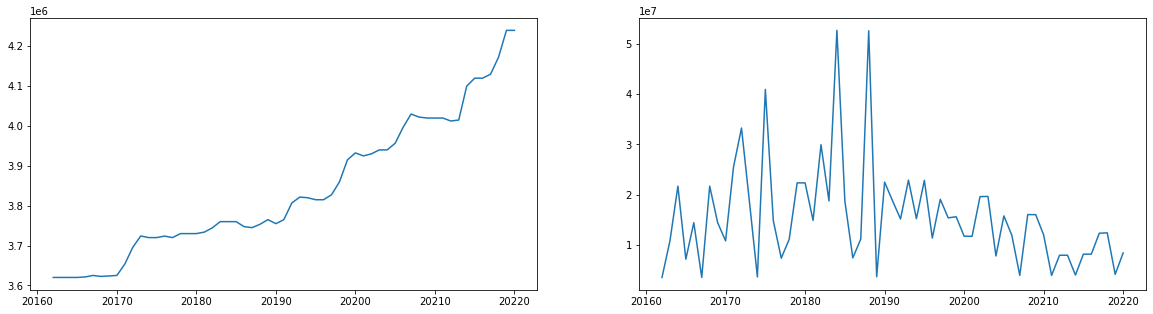

In [11]:
f, axes = plt.subplots(1, 2, figsize = (20,5))
sku_week.query("sku_id ==970").avg_price_by_week.plot(ax=axes[0])
sku_week.query("sku_id ==970").total_spent_by_week.plot(ax=axes[1])

<AxesSubplot:>

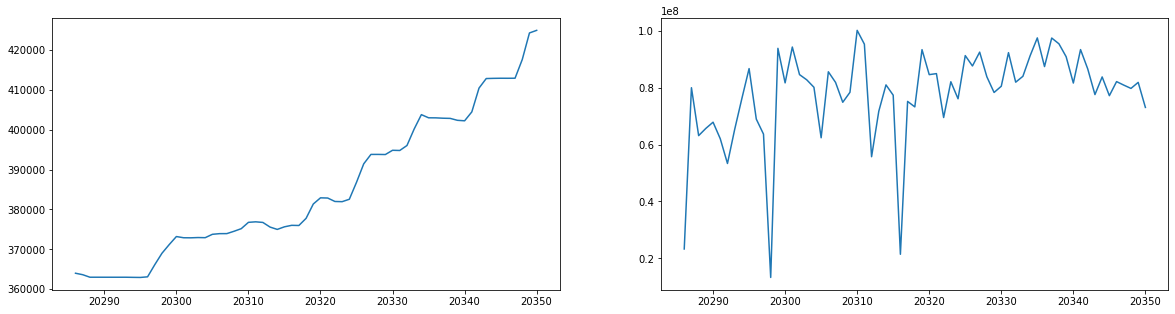

In [12]:
f, axes = plt.subplots(1, 2, figsize = (20,5))
sku_week.query("sku_id ==972").avg_price_by_week.plot(ax=axes[0])
sku_week.query("sku_id ==972").total_spent_by_week.plot(ax=axes[1])

<AxesSubplot:xlabel='avg_price_by_week', ylabel='total_spent_by_week'>

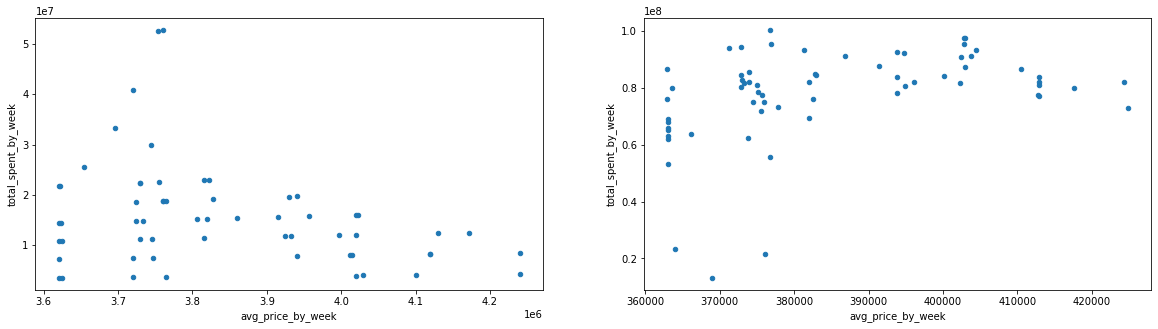

In [13]:
f, axes = plt.subplots(1, 2, figsize = (20,5))
sku_week.query("sku_id ==970").plot.scatter(x="avg_price_by_week", y="total_spent_by_week",ax=axes[0])
sku_week.query("sku_id ==972").plot.scatter(x="avg_price_by_week", y="total_spent_by_week",ax=axes[1])

In [14]:
sku_week_970 = sku_week.query("sku_id == 970").reset_index()
sku_week_972 = sku_week.query("sku_id == 972").reset_index()


### using Sklearn library to conduct regression analysis

 - study an individual SKU , e.g., 970, or 972

In [15]:
from sklearn.linear_model import LinearRegression
X = sku_week_970[["avg_price_by_week"]].values
y = sku_week_970["total_spent_by_week"].values
lr = LinearRegression() 
lr.fit(X, y) 

LinearRegression()

 - plot the data using scatter plot
 - plot the regression line using the predicted value of X, which should line up as a straight line as a linear model

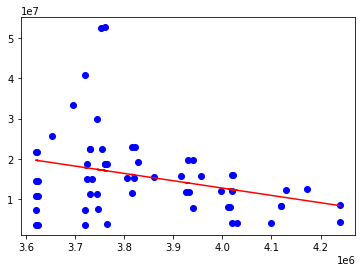

In [16]:
plt.scatter(X, y, c='blue')
plt.plot(X, lr.predict(X), color='red')    

 - print the coefficients and parameters
 - notice the negative beta, which seems to make sense wth the scatter plot of the data points

In [17]:
lr.coef_, lr.intercept_, lr.get_params(), lr.score(X,y)

(array([-18.18436086]),
 85495266.87350011,
 {'copy_X': True,
  'fit_intercept': True,
  'n_jobs': None,
  'normalize': 'deprecated',
  'positive': False},
 0.0920583515928346)

 - make a function for plotting

Slope: -18.184
Intercept: 85495266.874


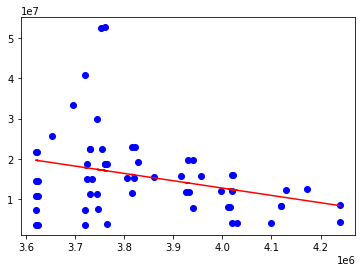

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')    
    return
print("Slope: %.3f" % lr.coef_[0]), print("Intercept: %.3f" % lr.intercept_)
lin_regplot(X, y, lr)

 - Let's do SKU 972

Slope: 366.882
Intercept: -63383595.655
Score: 0.155


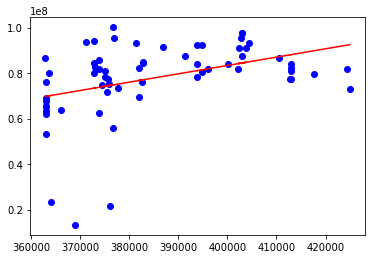

In [19]:
lr = LinearRegression()
X = sku_week_972[["avg_price_by_week"]].values
y = sku_week_972["total_spent_by_week"].values
lr = LinearRegression()
lr.fit(X, y)
print("Slope: %.3f" % lr.coef_[0]), print("Intercept: %.3f" % lr.intercept_)
print("Score: %.3f" % lr.score(X,y))
lin_regplot(X, y, lr)

 - notice the up-trending line, and notice the outliers at bottom or far right
 - should the regression line be more steep up trending for bigger increase in spent? or, should the regression line be more horizentally flat? 

### making robust regressions
 - using scikit-learn's RANSAC 

Slope: 5.858
Intercept: 79579429.336
Score: -0.052


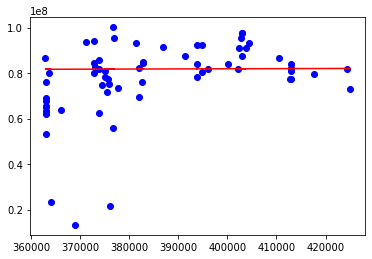

In [20]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(random_state=0)
X = sku_week_972[["avg_price_by_week"]].values
y = sku_week_972["total_spent_by_week"].values
ransac.fit(X,y)
lin_regplot(X, y, ransac)
print("Slope: %.3f" % ransac.estimator_.coef_[0])
print("Intercept: %.3f" % ransac.estimator_.intercept_)
print("Score: %.3f" % ransac.estimator_.score(X,y))

 - notice the fairly big changes in slope, intercept
 - score has reversed the sign

In [21]:
ransac.get_params(), ransac.estimator_.get_params()

({'base_estimator': 'deprecated',
  'estimator': None,
  'is_data_valid': None,
  'is_model_valid': None,
  'loss': 'absolute_error',
  'max_skips': inf,
  'max_trials': 100,
  'min_samples': None,
  'random_state': 0,
  'residual_threshold': None,
  'stop_n_inliers': inf,
  'stop_probability': 0.99,
  'stop_score': inf},
 {'copy_X': True,
  'fit_intercept': True,
  'n_jobs': None,
  'normalize': 'deprecated',
  'positive': False})

 - we need to know which points are considered inliers by RANSAC

In [22]:
ransac.inlier_mask_

array([False,  True, False, False, False, False, False, False,  True,
        True, False, False, False, False,  True, False,  True,  True,
        True, False,  True,  True, False,  True, False, False, False,
       False,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False])

 - this below is adapted from scikit-learn user guide/sample code

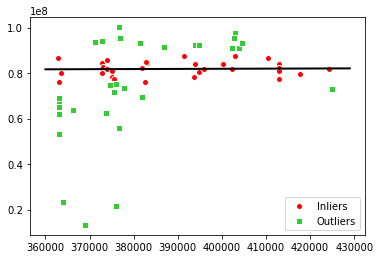

Slope: 5.858
Intercept: 79579429.336
Score: -0.052


In [23]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='red', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
line_X = np.arange(360000, 430000, 1000)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.legend(loc='lower right')
plt.show()
print("Slope: %.3f" % ransac.estimator_.coef_[0])
print("Intercept: %.3f" % ransac.estimator_.intercept_)
print("Score: %.3f" % ransac.score(X,y))


 - notice a big portion of the data are considered outliers 
 - can we adjust to have bigger range for inliers so that we have less points as outliers?
 - using the parameter residual_threshold to expand the inlier range
 - default residual_threshold is set as MAD (median absolute deviation) of y
 - for the data of sku_week_972 is 6461000.0

In [24]:
from scipy.stats import median_abs_deviation
median_abs_deviation(y), (max(y) - min(y))

(6461000.0, 86894500.0)

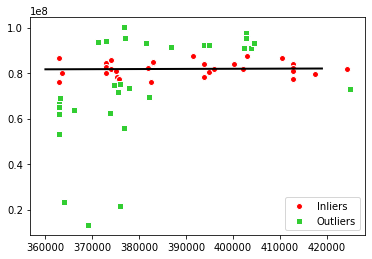

Slope: 5.858
Intercept: 79579429.336
Score: -0.052


In [25]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(residual_threshold=6461000.0, random_state=0) 
X = sku_week_972[["avg_price_by_week"]].values
y = sku_week_972["total_spent_by_week"].values
ransac.fit(X,y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(360000, 420000, 1000)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='red', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.legend(loc='lower right')
plt.show()
print("Slope: %.3f" % ransac.estimator_.coef_[0])
print("Intercept: %.3f" % ransac.estimator_.intercept_)
print("Score: %.3f" % ransac.estimator_.score(X,y))


 - if we plug in the entire range of y value (86894500.0) as the residual_threshold, it should include all data points as inliers

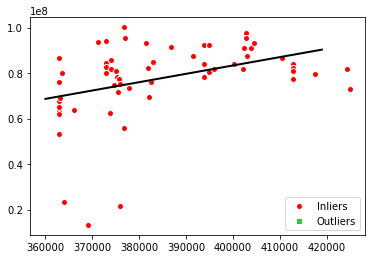

Slope: 366.882
Intercept: -63383595.655
Score: 0.155


In [26]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(residual_threshold=86894500.0,random_state=0)
#ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss='absolute_error',residual_threshold=30000000.0,random_state=0)
X = sku_week_972[["avg_price_by_week"]].values
y = sku_week_972["total_spent_by_week"].values
ransac.fit(X,y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(360000, 420000, 1000)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='red', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.legend(loc='lower right')
plt.show()
print("Slope: %.3f" % ransac.estimator_.coef_[0])
print("Intercept: %.3f" % ransac.estimator_.intercept_)
print("Score: %.3f" % ransac.estimator_.score(X,y))


 - notice the above generate the same regression results on the ordinary linear regression

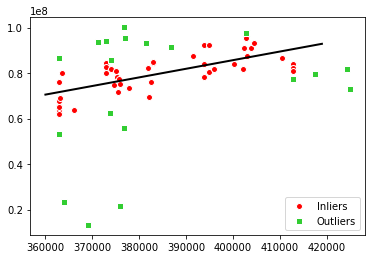

Slope: 378.390
Intercept: -65652727.816
Score: 0.137


In [27]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss='absolute_error',residual_threshold=10000000.0,random_state=0)
#ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss='absolute_error',residual_threshold=30000000.0,random_state=0)
X = sku_week_972[["avg_price_by_week"]].values
y = sku_week_972["total_spent_by_week"].values
ransac.fit(X,y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(360000, 420000, 1000)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='red', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.legend(loc='lower right')
plt.show()
print("Slope: %.3f" % ransac.estimator_.coef_[0])
print("Intercept: %.3f" % ransac.estimator_.intercept_)
print("Score: %.3f" % ransac.estimator_.score(X,y))


In [28]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]
betas = [0 * i for i in range(20)]
for i in range(20):
    sku_id = top_skus.iloc[i]['sku_id']
    #print(i), print(sku_id)
    X = sku_week[sku_week["sku_id"] ==sku_id][['avg_price_by_week']].values
    y = sku_week[sku_week["sku_id"] ==sku_id][['total_spent_by_week']].values 
    lr = LinearRegression() 
    lr.fit(X, y) 
    betas[i] = lr.coef_[0][0]
betas

[893.8609916450229,
 121.0152641476827,
 822.4805141449452,
 476.5055952808517,
 366.8819294608287,
 109.28176125209914,
 1405.1375076361312,
 383.2911899955827,
 663.6917872747402,
 -102.59839472139305,
 348.29838582177507,
 494.0430817151144,
 148.51223625501632,
 210.84378154328078,
 245.31533060507195,
 233.13779162652017,
 305.18146720289417,
 364.6444752053827,
 80.33991053743846,
 119.03818977806212]

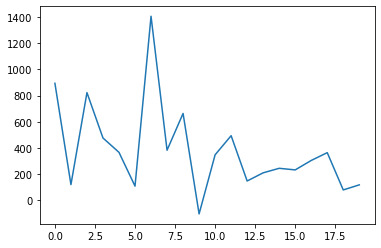

In [29]:
plt.plot(betas)

In [30]:
sku_attributes.sku_id.nunique()


1860

In [85]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]
sku_attributes[["beta"]] = 0
betas = [0 * i for i in range(num_sku)]
for i in range(num_sku):
    sku_id = sku_attributes.iloc[i]['sku_id']
    X = sku_week[sku_week["sku_id"] ==sku_id][['avg_price_by_week']].values
    y = sku_week[sku_week["sku_id"] ==sku_id][['total_spent_by_week']].values 
    lr = LinearRegression() 
    lr.fit(X, y) 
    betas[i] = lr.coef_[0][0]
    #print(i), print(sku_id), print(betas[i])
sku_attributes["beta"] = pd.DataFrame(betas)


In [86]:
sku_attributes.describe()

,sku_id,total_spent,num_orders,num_merchants,first_month,last_month,num_months,first_week,last_week,num_weeks,num_days,avg_spent_per_order,tenure_month,beta
count,1860.000000,1.860000e+03,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1.860000e+03,1860.000000,1.860000e+03
mean,930.500000,4.562067e+07,264.747312,38.048925,9.474731,18.356452,9.198387,12.446774,46.638172,25.589785,91.661828,1.493337e+05,9.881720,-3.423099e+03
std,537.080069,2.549065e+08,859.552039,45.183676,3.202155,6.706426,5.225923,13.417405,7.011536,18.319647,108.652305,3.234708e+05,5.224182,1.017991e+05
min,1.000000,3.000000e+04,3.000000,1.000000,6.000000,6.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.658537e+03,1.000000,-3.331574e+06
25%,465.750000,1.308625e+06,17.000000,7.000000,7.000000,10.000000,5.000000,1.000000,41.000000,9.000000,14.000000,4.034238e+04,5.000000,-1.120795e+01
50%,930.500000,4.515500e+06,56.000000,20.000000,10.000000,24.000000,8.000000,3.000000,51.000000,17.000000,42.000000,8.427154e+04,12.000000,0.000000e+00
75%,1395.250000,1.669562e+07,194.000000,51.000000,10.000000,24.000000,15.000000,25.000000,52.000000,46.000000,131.250000,1.597955e+05,15.000000,1.244100e+01
max,1860.000000,5.820716e+09,15119.000000,295.000000,24.000000,24.000000,15.000000,51.000000,52.000000,53.000000,430.000000,4.509845e+06,15.000000,3.165009e+05


In [83]:
pd.DataFrame(betas).describe()

,0
count,1.860000e+03
mean,-3.423099e+03
std,1.017991e+05
min,-3.331574e+06
25%,-1.120795e+01
50%,0.000000e+00
75%,1.244100e+01
max,3.165009e+05


In [84]:
sku_attributes = get_sku_attributes(baskets)
num_sku = sku_attributes.sku_id.nunique()
#sku_attributes['beta'] = 
betas = [0 * i for i in range(num_sku)]
for i in range(20):
    sku_id = sku_attributes.iloc[i]['sku_id']
    X = sku_week[sku_week["sku_id"] ==sku_id][['avg_price_by_week']].values
    y = sku_week[sku_week["sku_id"] ==sku_id][['total_spent_by_week']].values 
    lr = LinearRegression() 
    lr.fit(X, y) 
    print(lr.coef_[0][0])
    betas[i] = lr.coef_[0][0]
sku_attributes["beta"] = pd.DataFrame(betas)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [80]:
sku_attributes['beta'].head(30)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
Name: beta, dtype: int64